In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
GS_FILE='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gs_file/magma_10kb_1000.gs'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/results/fig_tcell'

df_gs = pd.read_csv(GS_FILE, sep='\t')
TRAIT_LIST_FULL = sorted(df_gs['TRAIT'])

# Data set info
DS_LIST = ['facs']
DIC_INFO = {}
DIC_INFO['facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}

# Set score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000'}


In [3]:
# Load raw data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['facs'] = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
                                  'tcell.facs.annot.h5ad')

# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    print('# Loading %s score'%score)
    for trait in TRAIT_LIST_FULL:
        score_file = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(score_file) is False:
            print('# Missing score file: %s'%trait)
        temp_df = pd.read_csv(score_file, sep='\t', index_col=0)
        temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
        temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
        dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)

# Align cell list 
dic_cell_list = {}
for ds in DS_LIST:
    dic_cell_list[ds] = list(set(dic_data_proc['facs'].obs_names) & set(dic_score[ds].index))
display(dic_data_raw[ds][dic_cell_list[ds],:].obs.groupby('cell_ontology_class').agg({'cell':len}))

Trying to set attribute `.obs` of view, copying.


# Loading facs score


,cell
cell_ontology_class,
"CD4-positive, alpha-beta T cell",1083
"CD8-positive, alpha-beta T cell",1019
T cell,1177
mature NK T cell,195
mature alpha-beta T cell,249
regulatory T cell,46


In [4]:
# Overall association
for ds in DS_LIST:
    print('# %s'%DIC_INFO[ds]['dname'])
    for trait in TRAIT_LIST_FULL:
        if '%s.fdr'%trait not in dic_score[ds].columns:
            print('# Missing %s'%trait)
            continue
        
        ind_select = (dic_score[ds].loc[dic_cell_list[ds], '%s.fdr'%trait]<0.1)
        if ind_select.mean()>0.01:
            print('# %s %0.3f'%(trait, ind_select.mean()))

# TMS FACS
# PASS_AdultOnsetAsthma_Ferreira2019 0.051
# PASS_CD_deLange2017 0.057
# PASS_Crohns_Disease 0.015
# PASS_IBD 0.097
# PASS_IBD_deLange2017 0.094
# PASS_Multiple_sclerosis 0.104
# PASS_Rheumatoid_Arthritis 0.207
# PASS_UC_deLange2017 0.011
# UKB_460K.blood_EOSINOPHIL_COUNT 0.296
# UKB_460K.blood_LYMPHOCYTE_COUNT 0.090
# UKB_460K.blood_MONOCYTE_COUNT 0.010
# UKB_460K.disease_AID_ALL 0.305
# UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED 0.170
# UKB_460K.disease_ASTHMA_DIAGNOSED 0.144
# UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 0.346
# UKB_460K.disease_RESPIRATORY_ENT 0.273
# UKB_460K.disease_THYROID_ANY_SELF_REP 0.419


In [33]:
temp_df = pd.read_csv(DATA_PATH+'/score_file/score.tms_facs_with_cov.gwas_max_abs_z.top500/PASS_IBD.score.gz',
                      sep='\t', index_col=0)

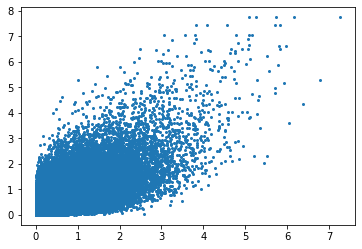

In [38]:
plt.figure()
plt.scatter(temp_df['nlog10_pval'], dic_score['facs']['PASS_IBD.nlog10_pval'], s=4)
plt.show()